In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
from Clients.mcp.mcpClientFactory import create_mcp_client
from langchain.chat_models import init_chat_model
from IPython.display import Image, display
from langchain_core.tools import tool

In [6]:
mcp_client = create_mcp_client()
msp_tools = None

if mcp_client:
    mcp_tools = await mcp_client.get_tools()
    print("Tools loaded successfully, grabbed total of", len(mcp_tools), "tools.")
    mcp_tools = mcp_tools if mcp_tools else None


# Define non - MCP tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = mcp_tools + [add, multiply, divide]

tools_by_name = {tool.name: tool for tool in tools}

Loaded MCP config: {'azure-devops': {'command': 'npx', 'args': ['-y', '@tiberriver256/mcp-server-azure-devops'], 'env': {'AZURE_DEVOPS_ORG_URL': 'https://msazure.visualstudio.com/', 'AZURE_DEVOPS_AUTH_METHOD': 'azure-identity', 'AZURE_DEVOPS_DEFAULT_PROJECT': 'One'}, 'transport': 'stdio'}, 'filesystem': {'command': 'npx', 'args': ['-y', '@modelcontextprotocol/server-filesystem', '/home/mateoruiz/AgentTest'], 'transport': 'stdio'}}
Tools loaded successfully, grabbed total of 44 tools.


In [3]:
import dotenv
dotenv.load_dotenv()

model = init_chat_model(
            "o3-mini",
            model_provider="azure_openai"
        )     
if tools:
    model = model.bind_tools(tools)


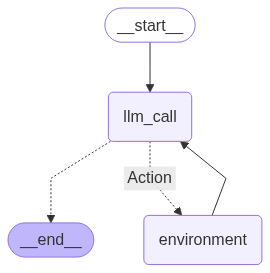

[debug] {'step': 1, 'timestamp': '2025-07-07T22:03:09.931259+00:00', 'type': 'task', 'payload': {'id': 'fffc82fe-8c14-0770-d5b0-2af2b6d8eb3b', 'name': 'llm_call', 'input': {'messages': [HumanMessage(content='Howdy, what tasks do I have assigned to myself today?', additional_kwargs={}, response_metadata={}, id='431f4d22-ce83-4479-b570-38aa2b1ae668')]}, 'triggers': ('branch:to:llm_call',)}}
[debug] {'step': 1, 'timestamp': '2025-07-07T22:03:25.462546+00:00', 'type': 'task_result', 'payload': {'id': 'fffc82fe-8c14-0770-d5b0-2af2b6d8eb3b', 'name': 'llm_call', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TUEAymxKI1cUW82x0rra4Hb5', 'function': {'arguments': '{"projectId": "One", "organizationId": "unknown-organization", "wiql": "Select [System.Id], [System.Title] from WorkItems where [System.AssignedTo] = @Me and [System.WorkItemType] = \'Task\' and [Microsoft.VSTS.Scheduling.DueDate] = @Today"}', 'name': 'list_work_items'}, 'ty

In [7]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a helpful agent that can use tools to assist the user."
                    )
                ]
                + state["messages"]
            )
        ]
    }


async def tool_node(state: dict):
    """Performs the tool call (async version for MCP tools)"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        
        # Use async invocation for MCP tools, fallback to sync for others
        if hasattr(tool, 'ainvoke'):
            observation = await tool.ainvoke(tool_call["args"])
        else:
            observation = tool.invoke(tool_call["args"])
            
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Howdy, what tasks do I have assigned to myself today?")]
messages = await agent.ainvoke({"messages": messages}, print_mode="debug")
for m in messages["messages"]:
    m.pretty_print()

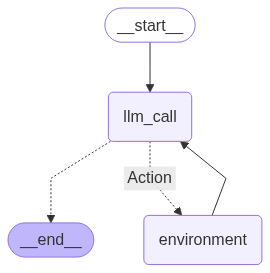

[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:20.915399+00:00', 'type': 'task', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'input': {'messages': [HumanMessage(content='Howdy, what tasks do I have assigned to myself today?', additional_kwargs={}, response_metadata={}, id='aaf13171-a177-4319-97f9-ba4f1fc806b9')]}, 'triggers': ('branch:to:llm_call',)}}
[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:33.983171+00:00', 'type': 'task_result', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6RacV3WrZ7MAnfL75H57BkLq', 'function': {'arguments': '{"projectId": "One", "wiql": "Select [System.Id], [System.Title] From WorkItems Where [System.AssignedTo] = @Me and [System.WorkItemType] = \'Task\' and [System.State] <> \'Closed\' and [Microsoft.VSTS.Scheduling.DueDate] = @Today"}', 'name': 'list_work_items'}, 'type': 'fun

TypeError: No synchronous function provided to "environment".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with helping navigate and manage Azure Dev Ops"
                    )
                ]
                + state["messages"]
            )
        ]
    }


async def tool_node(state: dict):
    """Performs the tool call (async version for MCP tools)"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        
        # Use async invocation for MCP tools, fallback to sync for others
        if hasattr(tool, 'ainvoke'):
            observation = await tool.ainvoke(tool_call["args"])
        else:
            observation = tool.invoke(tool_call["args"])
            
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Howdy, what tasks do I have assigned to myself today?")]
messages = agent.invoke({"messages": messages}, print_mode="debug")
for m in messages["messages"]:
    m.pretty_print()

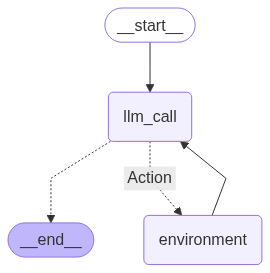

[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:20.915399+00:00', 'type': 'task', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'input': {'messages': [HumanMessage(content='Howdy, what tasks do I have assigned to myself today?', additional_kwargs={}, response_metadata={}, id='aaf13171-a177-4319-97f9-ba4f1fc806b9')]}, 'triggers': ('branch:to:llm_call',)}}
[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:33.983171+00:00', 'type': 'task_result', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6RacV3WrZ7MAnfL75H57BkLq', 'function': {'arguments': '{"projectId": "One", "wiql": "Select [System.Id], [System.Title] From WorkItems Where [System.AssignedTo] = @Me and [System.WorkItemType] = \'Task\' and [System.State] <> \'Closed\' and [Microsoft.VSTS.Scheduling.DueDate] = @Today"}', 'name': 'list_work_items'}, 'type': 'fun

TypeError: No synchronous function provided to "environment".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with helping navigate and manage Azure Dev Ops"
                    )
                ]
                + state["messages"]
            )
        ]
    }


async def tool_node(state: dict):
    """Performs the tool call (async version for MCP tools)"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        
        # Use async invocation for MCP tools, fallback to sync for others
        if hasattr(tool, 'ainvoke'):
            observation = await tool.ainvoke(tool_call["args"])
        else:
            observation = tool.invoke(tool_call["args"])
            
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Howdy, what tasks do I have assigned to myself today?")]
messages = agent.invoke({"messages": messages}, print_mode="debug")
for m in messages["messages"]:
    m.pretty_print()

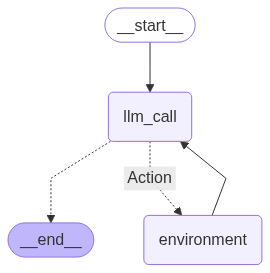

[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:20.915399+00:00', 'type': 'task', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'input': {'messages': [HumanMessage(content='Howdy, what tasks do I have assigned to myself today?', additional_kwargs={}, response_metadata={}, id='aaf13171-a177-4319-97f9-ba4f1fc806b9')]}, 'triggers': ('branch:to:llm_call',)}}
[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:33.983171+00:00', 'type': 'task_result', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6RacV3WrZ7MAnfL75H57BkLq', 'function': {'arguments': '{"projectId": "One", "wiql": "Select [System.Id], [System.Title] From WorkItems Where [System.AssignedTo] = @Me and [System.WorkItemType] = \'Task\' and [System.State] <> \'Closed\' and [Microsoft.VSTS.Scheduling.DueDate] = @Today"}', 'name': 'list_work_items'}, 'type': 'fun

TypeError: No synchronous function provided to "environment".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with helping navigate and manage Azure Dev Ops"
                    )
                ]
                + state["messages"]
            )
        ]
    }


async def tool_node(state: dict):
    """Performs the tool call (async version for MCP tools)"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        
        # Use async invocation for MCP tools, fallback to sync for others
        if hasattr(tool, 'ainvoke'):
            observation = await tool.ainvoke(tool_call["args"])
        else:
            observation = tool.invoke(tool_call["args"])
            
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Howdy, what tasks do I have assigned to myself today?")]
messages = agent.invoke({"messages": messages}, print_mode="debug")
for m in messages["messages"]:
    m.pretty_print()

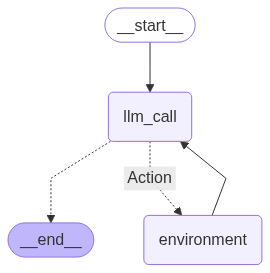

[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:20.915399+00:00', 'type': 'task', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'input': {'messages': [HumanMessage(content='Howdy, what tasks do I have assigned to myself today?', additional_kwargs={}, response_metadata={}, id='aaf13171-a177-4319-97f9-ba4f1fc806b9')]}, 'triggers': ('branch:to:llm_call',)}}
[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:33.983171+00:00', 'type': 'task_result', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6RacV3WrZ7MAnfL75H57BkLq', 'function': {'arguments': '{"projectId": "One", "wiql": "Select [System.Id], [System.Title] From WorkItems Where [System.AssignedTo] = @Me and [System.WorkItemType] = \'Task\' and [System.State] <> \'Closed\' and [Microsoft.VSTS.Scheduling.DueDate] = @Today"}', 'name': 'list_work_items'}, 'type': 'fun

TypeError: No synchronous function provided to "environment".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with helping navigate and manage Azure Dev Ops"
                    )
                ]
                + state["messages"]
            )
        ]
    }


async def tool_node(state: dict):
    """Performs the tool call (async version for MCP tools)"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        
        # Use async invocation for MCP tools, fallback to sync for others
        if hasattr(tool, 'ainvoke'):
            observation = await tool.ainvoke(tool_call["args"])
        else:
            observation = tool.invoke(tool_call["args"])
            
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Howdy, what tasks do I have assigned to myself today?")]
messages = agent.invoke({"messages": messages}, print_mode="debug")
for m in messages["messages"]:
    m.pretty_print()

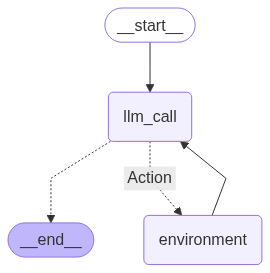

[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:20.915399+00:00', 'type': 'task', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'input': {'messages': [HumanMessage(content='Howdy, what tasks do I have assigned to myself today?', additional_kwargs={}, response_metadata={}, id='aaf13171-a177-4319-97f9-ba4f1fc806b9')]}, 'triggers': ('branch:to:llm_call',)}}
[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:33.983171+00:00', 'type': 'task_result', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6RacV3WrZ7MAnfL75H57BkLq', 'function': {'arguments': '{"projectId": "One", "wiql": "Select [System.Id], [System.Title] From WorkItems Where [System.AssignedTo] = @Me and [System.WorkItemType] = \'Task\' and [System.State] <> \'Closed\' and [Microsoft.VSTS.Scheduling.DueDate] = @Today"}', 'name': 'list_work_items'}, 'type': 'fun

TypeError: No synchronous function provided to "environment".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with helping navigate and manage Azure Dev Ops"
                    )
                ]
                + state["messages"]
            )
        ]
    }


async def tool_node(state: dict):
    """Performs the tool call (async version for MCP tools)"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        
        # Use async invocation for MCP tools, fallback to sync for others
        if hasattr(tool, 'ainvoke'):
            observation = await tool.ainvoke(tool_call["args"])
        else:
            observation = tool.invoke(tool_call["args"])
            
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Howdy, what tasks do I have assigned to myself today?")]
messages = agent.invoke({"messages": messages}, print_mode="debug")
for m in messages["messages"]:
    m.pretty_print()

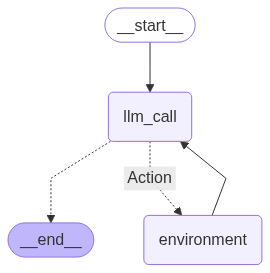

[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:20.915399+00:00', 'type': 'task', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'input': {'messages': [HumanMessage(content='Howdy, what tasks do I have assigned to myself today?', additional_kwargs={}, response_metadata={}, id='aaf13171-a177-4319-97f9-ba4f1fc806b9')]}, 'triggers': ('branch:to:llm_call',)}}
[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:33.983171+00:00', 'type': 'task_result', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6RacV3WrZ7MAnfL75H57BkLq', 'function': {'arguments': '{"projectId": "One", "wiql": "Select [System.Id], [System.Title] From WorkItems Where [System.AssignedTo] = @Me and [System.WorkItemType] = \'Task\' and [System.State] <> \'Closed\' and [Microsoft.VSTS.Scheduling.DueDate] = @Today"}', 'name': 'list_work_items'}, 'type': 'fun

TypeError: No synchronous function provided to "environment".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with helping navigate and manage Azure Dev Ops"
                    )
                ]
                + state["messages"]
            )
        ]
    }


async def tool_node(state: dict):
    """Performs the tool call (async version for MCP tools)"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        
        # Use async invocation for MCP tools, fallback to sync for others
        if hasattr(tool, 'ainvoke'):
            observation = await tool.ainvoke(tool_call["args"])
        else:
            observation = tool.invoke(tool_call["args"])
            
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Howdy, what tasks do I have assigned to myself today?")]
messages = agent.invoke({"messages": messages}, print_mode="debug")
for m in messages["messages"]:
    m.pretty_print()

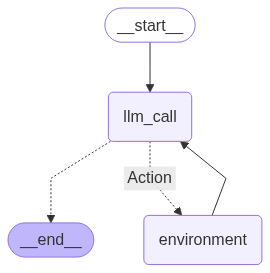

[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:20.915399+00:00', 'type': 'task', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'input': {'messages': [HumanMessage(content='Howdy, what tasks do I have assigned to myself today?', additional_kwargs={}, response_metadata={}, id='aaf13171-a177-4319-97f9-ba4f1fc806b9')]}, 'triggers': ('branch:to:llm_call',)}}
[debug] {'step': 1, 'timestamp': '2025-07-07T20:42:33.983171+00:00', 'type': 'task_result', 'payload': {'id': '99627e82-03da-8d1c-f03c-52fc22dff463', 'name': 'llm_call', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6RacV3WrZ7MAnfL75H57BkLq', 'function': {'arguments': '{"projectId": "One", "wiql": "Select [System.Id], [System.Title] From WorkItems Where [System.AssignedTo] = @Me and [System.WorkItemType] = \'Task\' and [System.State] <> \'Closed\' and [Microsoft.VSTS.Scheduling.DueDate] = @Today"}', 'name': 'list_work_items'}, 'type': 'fun

TypeError: No synchronous function provided to "environment".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with helping navigate and manage Azure Dev Ops"
                    )
                ]
                + state["messages"]
            )
        ]
    }


async def tool_node(state: dict):
    """Performs the tool call (async version for MCP tools)"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        
        # Use async invocation for MCP tools, fallback to sync for others
        if hasattr(tool, 'ainvoke'):
            observation = await tool.ainvoke(tool_call["args"])
        else:
            observation = tool.invoke(tool_call["args"])
            
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Howdy, what tasks do I have assigned to myself today?")]
messages = agent.invoke({"messages": messages}, print_mode="debug")
for m in messages["messages"]:
    m.pretty_print()